## Homework 11 Assignment 2

In [1]:
# set working environment and imports
import pandas as pd
import numpy as np
import urllib
import os
from zipfile import ZipFile
import json
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from descartes import PolygonPatch
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Download the Data
I manually downloaded the datasets, and placed the zip folders in the census_zip directory on my local machine.

In [2]:
# first set range: data spans betwenn 1994 and 2014 inclusively
years = range(1995,2015)

# create empty dataframe to store datasets
df = pd.DataFrame()

# for loop to unzip and read each dataset, then fix column formatting, subset columns, and merge together
for year in years:
    abbr_year = str(year)[2:4]
    fname = 'zbp' + abbr_year + 'totals.zip'
    fullname = "/Users/kaylynlevine/Desktop/cluster/census_zip/" + fname
    zf = ZipFile(fullname)
    # open and read file
    df_that_year = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    # make column names uniform 
    df_that_year.columns = [item.upper() for item in df_that_year.columns] 
    df_that_year['YEAR'] = year
    # subset columns we need for the analysis
    df_sliced = df_that_year.loc[:,['ZIP','EST','YEAR']]
    # merge dataframes using concat
    df = pd.concat([df, df_sliced], axis=0)

In [3]:
# check dataframe
df.head()

,ZIP,EST,YEAR
0,501,2,1995
1,1000,4,1995
2,1001,439,1995
3,1002,467,1995
4,1003,10,1995


In [4]:
# uson json to open the geojson file downloaded from the professor's github
with open("/Users/kaylynlevine/Desktop/cluster/nyc-zip-code-tabulation-areas-polygons.geojson") as f:
    geojson = pd.DataFrame(json.load(f))

In [5]:
geojson.head()

,features,type
0,"{u'geometry': {u'type': u'Polygon', u'coordina...",FeatureCollection
1,"{u'geometry': {u'type': u'Polygon', u'coordina...",FeatureCollection
2,"{u'geometry': {u'type': u'Polygon', u'coordina...",FeatureCollection
3,"{u'geometry': {u'type': u'Polygon', u'coordina...",FeatureCollection
4,"{u'geometry': {u'type': u'Polygon', u'coordina...",FeatureCollection


In [6]:
# create zipcode and polygon empty dictionaries
zipcodes = []
polygons = []

# for loop to populate the new dictionaries
for i in range(len(geojson)):
    zc = geojson.ix[i]['features']['properties']['postalCode']
    poly = geojson.ix[i]['features']['geometry']
    zipcodes.append(int(zc))
    polygons.append(poly)
nyc_shape = pd.DataFrame({'geometry': polygons, 'ZIP':zipcodes})

In [7]:
nyc_shape.head()

,ZIP,geometry
0,11372,"{u'type': u'Polygon', u'coordinates': [[[-73.8..."
1,11004,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
2,11040,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
3,11426,"{u'type': u'Polygon', u'coordinates': [[[-73.7..."
4,11365,"{u'type': u'Polygon', u'coordinates': [[[-73.8..."


In [8]:
# merge the datasets
# first clean census data

# set index to zipcodes
df.index = df.ZIP

# drop nan
df_new = df.ix[zipcodes].dropna()

# convert columns from string to integer values
df_new['ZIP'] = df_new['ZIP'].astype(int)
df_new['YEAR'] = df_new['YEAR'].astype(int)

In [9]:
# use pivot_table function
# this manipulates the dataframe table to show both year and zip code values 
df_pivot = df_new.pivot_table(index='ZIP', columns='YEAR', values='EST')
df_pivot.head()

YEAR,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,
10001,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,3776.0,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,1226.0,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [10]:
# check to make sure data is correct
df_pivot.shape

(244, 20)

In [11]:
# standardize the values
# first drop nan
df_standard = df_pivot.dropna().copy()

# define for loop to calculate standardized numbers for each cell in the dataframe
for r in df_standard.index:
    values = df_pivot.ix[r]
    mean = values.mean()
    std = values.std()
    df_standard.ix[r] = (values - mean) / std


In [12]:
df_standard.head()

YEAR,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,
10001,-1.381360,-1.482758,-0.866567,-0.086579,-0.250376,0.404814,-0.601371,-0.967966,-1.412559,0.818208,0.365815,1.169203,2.214387,1.613796,0.311215,-0.187977,-0.297176,-0.234777,0.061619,0.810408
10002,-1.814430,-1.550589,-1.207597,-1.328964,-1.112615,-0.606041,0.095774,-0.627148,-0.276241,0.116881,0.462512,0.473066,0.470427,0.486258,0.707884,0.963809,1.069345,1.180158,1.269863,1.227649
10003,-1.636189,-1.499399,-1.095866,-0.706012,-0.671814,-0.589740,-0.866741,-0.818864,-0.517924,-0.271701,0.039498,0.183129,0.661897,0.737132,0.832885,0.880762,1.038072,1.226159,1.441604,1.633112
10004,-1.573020,-1.495680,-1.151944,-1.126164,-0.636341,-0.112144,-0.516033,-0.464473,-0.473066,-0.206671,-0.404319,0.033944,0.540954,0.592514,0.618294,0.781569,0.833129,1.159678,1.477633,2.122138
10005,-3.070763,-0.771451,-0.535073,0.388949,-0.212740,0.754260,-0.062318,-0.169762,-1.115274,-0.556562,-0.814429,0.152571,0.453416,0.840216,0.474905,0.302993,1.055105,0.453416,0.947660,1.484883


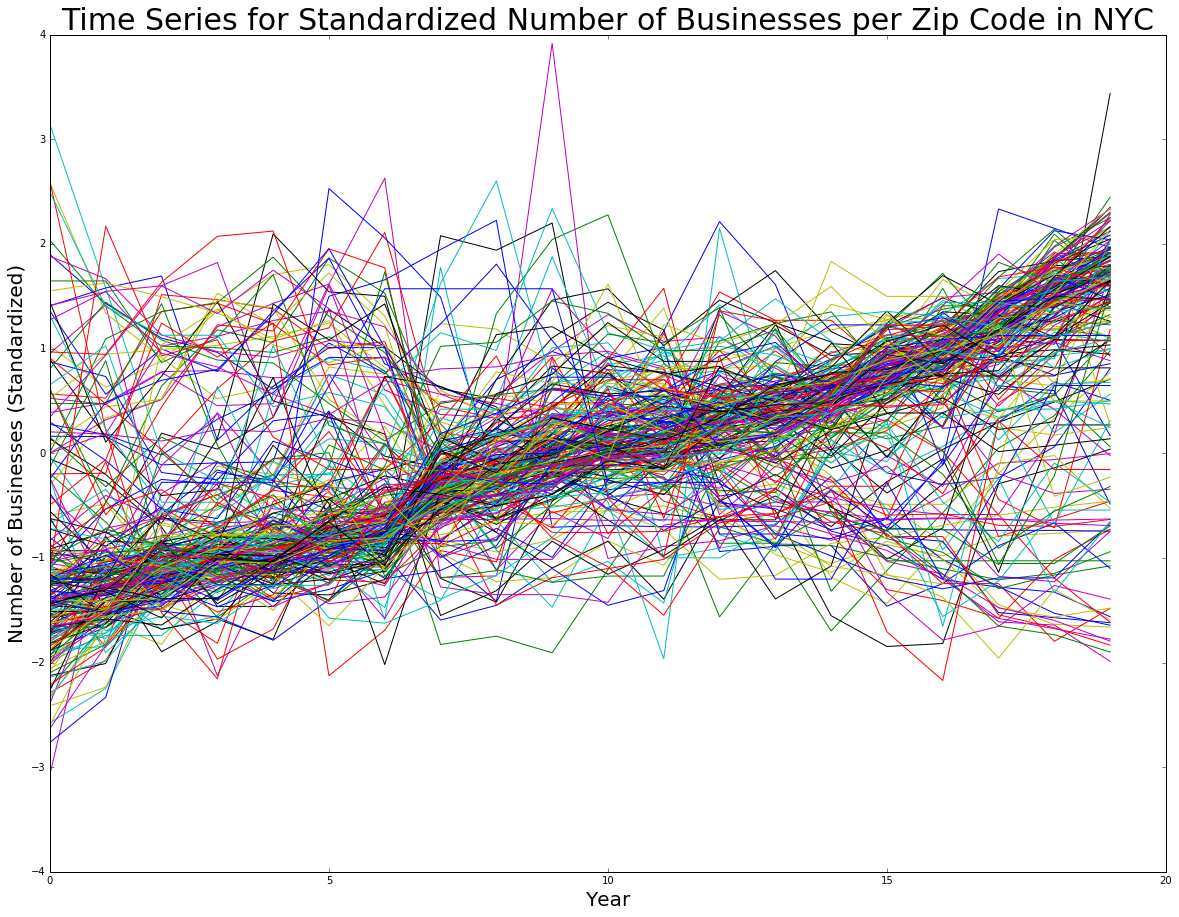

In [13]:
# plot timeseries for standardized dataset
pl.figure(figsize=(20,15))
for i in range(len(df_standard)):
    pl.plot(df_standard.iloc[i,:].values)  

pl.xlabel('Year', size = 20)
pl.ylabel('Number of Businesses (Standardized)', size = 20)
pl.title('Time Series for Standardized Number of Businesses per Zip Code in NYC', size = 30)

In [37]:
# this function came from Mona, which originated in ADS class
def elbow(data, K):
    '''This function calculates the average within-cluster
    sum of squares, and plots the "elbow curve"'''
    
    KM = [KMeans(n_clusters = k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    globals()['dist'] = [np.min(D, axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = pl.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    pl.grid(True)
    pl.xlabel('Cluster Numbers')
    pl.ylabel('Avg in-cluster sum of squares')
    pl.title('Elbow Plot for KM Clustering Type', fontsize = 15)


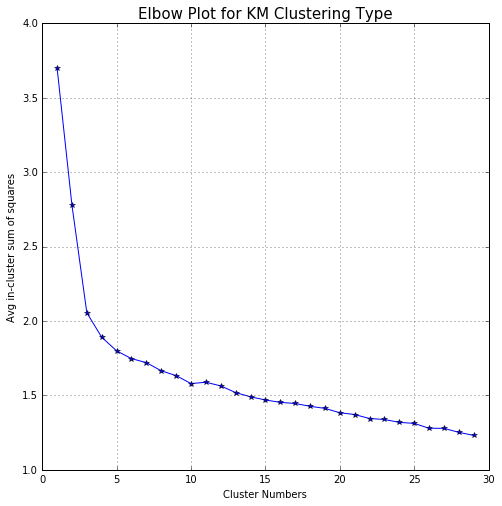

In [38]:
# plot elbow
elbow(df_standard, range(1,30))

#### Clustering Type: K-Means

In [16]:
# k-means clustering
km_cluster = KMeans(5).fit(df_standard)

In [17]:
# create column to store km
df_standard['km'] = km_cluster.labels_

In [18]:
df_standard.head()

YEAR,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,km
ZIP,,,,,,,,,,,,,,,,,,,,,
10001,-1.381360,-1.482758,-0.866567,-0.086579,-0.250376,0.404814,-0.601371,-0.967966,-1.412559,0.818208,...,1.169203,2.214387,1.613796,0.311215,-0.187977,-0.297176,-0.234777,0.061619,0.810408,0
10002,-1.814430,-1.550589,-1.207597,-1.328964,-1.112615,-0.606041,0.095774,-0.627148,-0.276241,0.116881,...,0.473066,0.470427,0.486258,0.707884,0.963809,1.069345,1.180158,1.269863,1.227649,0
10003,-1.636189,-1.499399,-1.095866,-0.706012,-0.671814,-0.589740,-0.866741,-0.818864,-0.517924,-0.271701,...,0.183129,0.661897,0.737132,0.832885,0.880762,1.038072,1.226159,1.441604,1.633112,4
10004,-1.573020,-1.495680,-1.151944,-1.126164,-0.636341,-0.112144,-0.516033,-0.464473,-0.473066,-0.206671,...,0.033944,0.540954,0.592514,0.618294,0.781569,0.833129,1.159678,1.477633,2.122138,4
10005,-3.070763,-0.771451,-0.535073,0.388949,-0.212740,0.754260,-0.062318,-0.169762,-1.115274,-0.556562,...,0.152571,0.453416,0.840216,0.474905,0.302993,1.055105,0.453416,0.947660,1.484883,0


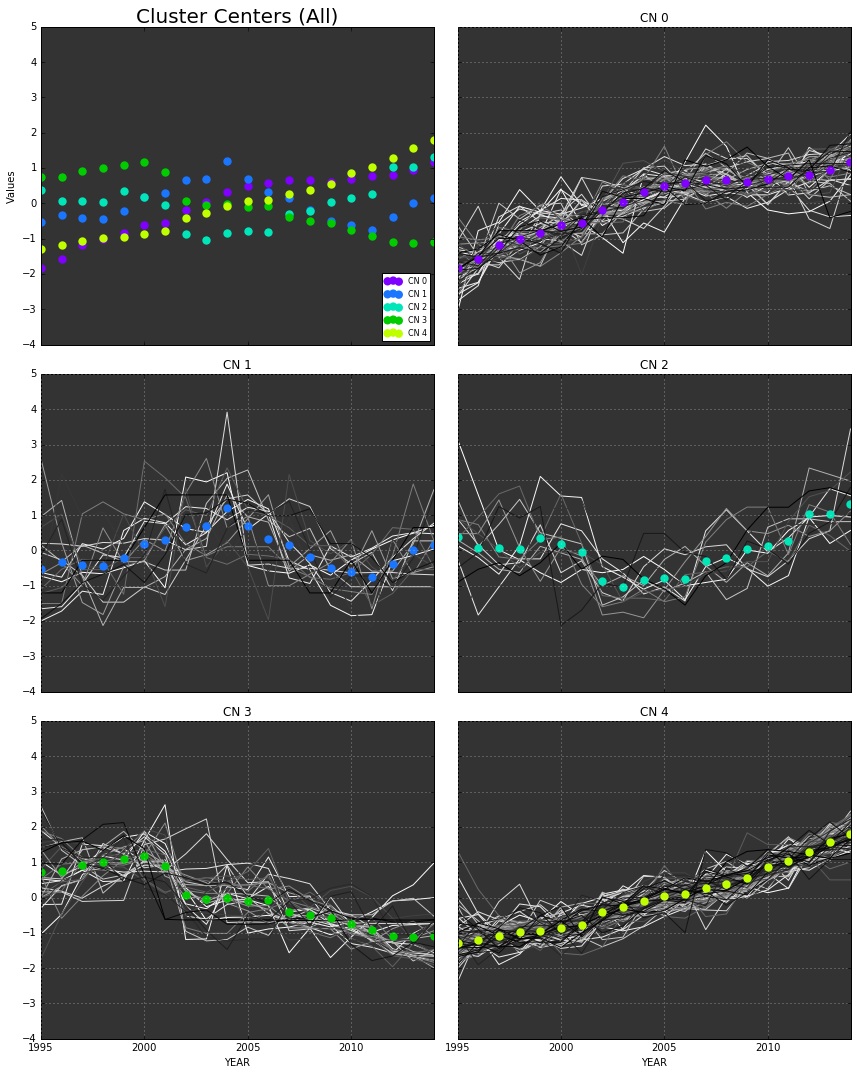

In [23]:
# plot clusters
fig = pl.figure(figsize=(12,15))
ax1 = fig.add_subplot(3,2,1)
ax1.set_axis_bgcolor("#333333")
c = ['#8000ff','#1a75ff','#00e6b8','#00cc00','#bfff00']

# initial subplot: shows all cluster centers in one graph
for i in range(5):
    ax1.scatter(years,km_cluster.cluster_centers_[i], c=c[i], lw=0, s=70, label='CN ' + str(i))
ax1.legend(loc='lower right', fontsize=8)
ax1.set_title('Cluster Centers (All)', fontsize = 20)
ax1.set_xlabel('Year')
ax1.set_ylabel('Values')
ax1.set_ylim(-3,4)

# following subplots: shows cluster center timeseries
for sn in [2, 3, 4, 5, 6]:
    ax = fig.add_subplot(3, 2, sn, sharex = ax1, sharey = ax1)
    features = df_standard.iloc[:, 0:20]
    cluster = sn - 2
    features[df_standard['km'] == cluster].T.plot(legend = False, cmap = 'Greys', ax = ax, zorder = 1)
    ax.scatter(years, km_cluster.cluster_centers_[cluster], c = c[cluster], zorder = 2, lw = 0, s = 70)
    ax.set_title('CN '+ str(cluster))
    ax.grid(color = '#e6e6e6')
    ax.set_axis_bgcolor("#333333")
pl.tight_layout()

#### Figure Caption:
These subplots illustrate K-Means clustering for cluster numbers 1 through 5 (0-4 in the plots). The first plot shows each cluster center plotted against each other. The following plots show specific cluster number timeseries.

#### Second Type of Clustering: Hierarchical


In [25]:
# select all features from the dataset and store in new variable
X = df_standard.iloc[:, 0:20]

In [26]:
# link observations
links = linkage(X, 'ward')

AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

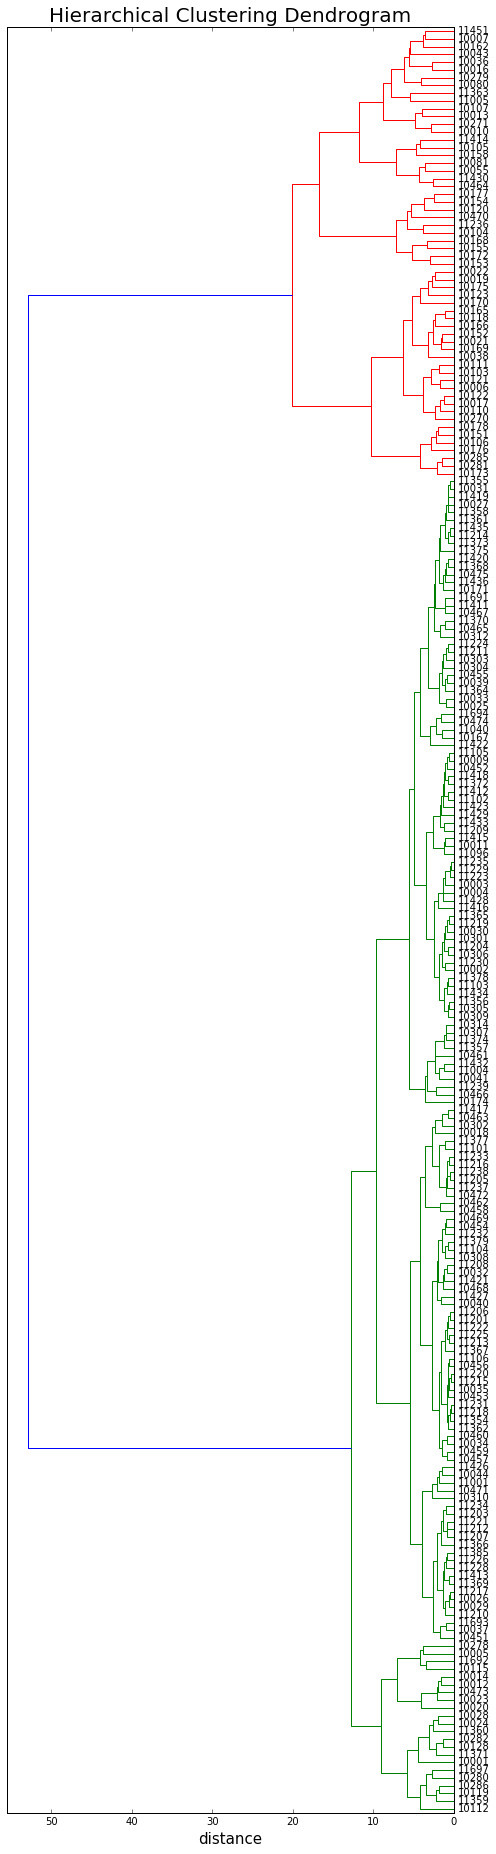

In [27]:
# dendrogram plot
pl.figure(figsize=(8, 32))
pl.title('Hierarchical Clustering Dendrogram', fontsize=20)
pl.xlabel('distance', fontsize=15)
dendrogram(links, leaf_font_size=10, orientation='left', labels=X.index)


In [28]:
# choose 5 clusters from hierarchical clustering
k = 5

# store the labels in the dataframe as a new column
df_standard['hierarchical'] = fcluster(links, k, criterion='maxclust')

#### Map the data
Add both clustering types to nyc_shape dataframe to make visualizations.

In [29]:
# km clustering
labels = pd.DataFrame(df_standard['km']).reset_index()
nyc_shape = pd.merge(nyc_shape, labels, how='left', on='ZIP')
nyc_shape.fillna(-1, inplace=True)

In [30]:
# hierarchical clustering
labels = pd.DataFrame(df_standard['hierarchical']).reset_index()
nyc_shape = pd.merge(nyc_shape, labels, how='left', on='ZIP')
nyc_shape.fillna(0, inplace=True) # because first cluster start from 1


In [31]:
nyc_shape.head()

,ZIP,geometry,km,hierarchical
0,11372,"{u'type': u'Polygon', u'coordinates': [[[-73.8...",4.0,2.0
1,11004,"{u'type': u'Polygon', u'coordinates': [[[-73.7...",0.0,2.0
2,11040,"{u'type': u'Polygon', u'coordinates': [[[-73.7...",4.0,2.0
3,11426,"{u'type': u'Polygon', u'coordinates': [[[-73.7...",4.0,2.0
4,11365,"{u'type': u'Polygon', u'coordinates': [[[-73.8...",4.0,2.0


### Clustering Number: 5

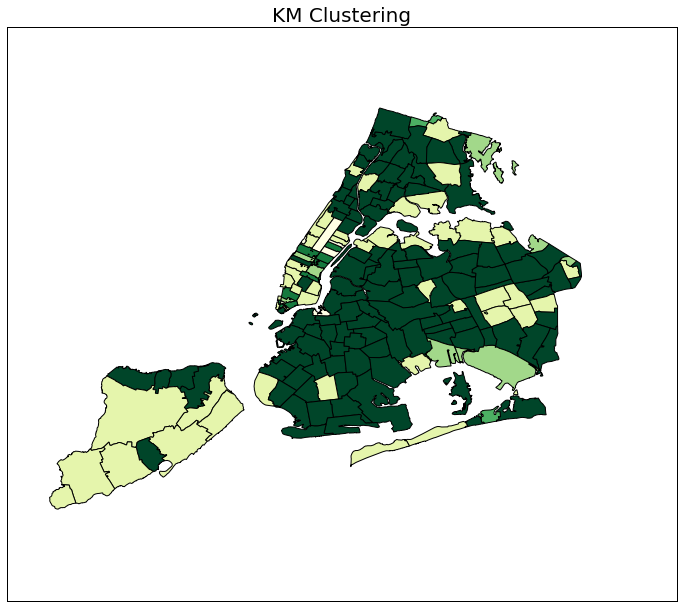

In [33]:
# map km clustering
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(111)
colors = np.linspace(0, 1, 5+1)
cmap = cm.get_cmap('YlGn')
for i in range(len(nyc_shape)):
    poly = nyc_shape['geometry'][i]
    if ('km' == 'hierarchical') | ('km' == 'hierarchical2'):
        color_index = int(nyc_shape['km'][i])
    else:
        color_index = int(nyc_shape['km'][i]+1)
    color = cmap(colors[color_index])
    ax.add_patch(PolygonPatch(poly, fc=color, ec='k', zorder=2))
ax.axis('scaled')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('KM' + ' Clustering', fontsize=20)

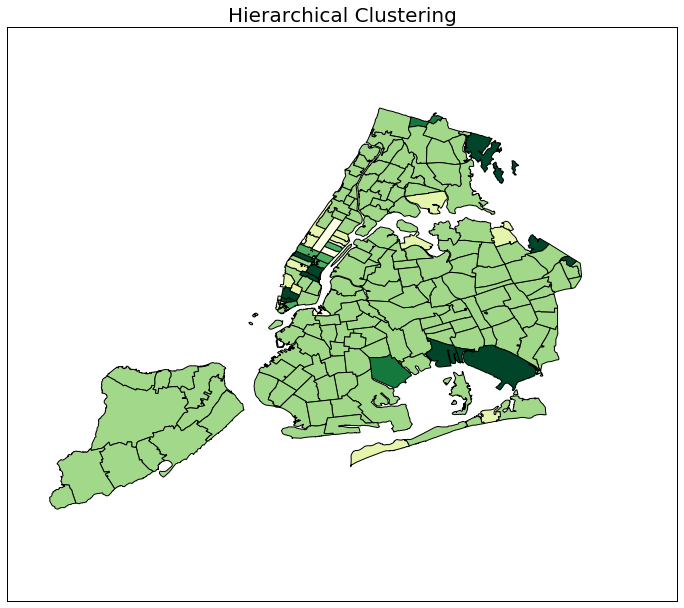

In [34]:
# map hierarchical clustering
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(111)
colors = np.linspace(0, 1, 5+1)
cmap = cm.get_cmap('YlGn')
for i in range(len(nyc_shape)):
    poly = nyc_shape['geometry'][i]
    if ('hierarchical' == 'hierarchical') | ('hierarchical' == 'hierarchical2'):
        color_index = int(nyc_shape['hierarchical'][i])
    else:
        color_index = int(nyc_shape['hierarchical'][i]+1)
    color = cmap(colors[color_index])
    ax.add_patch(PolygonPatch(poly, fc=color, ec='k', zorder=2))
ax.axis('scaled')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Hierarchical' + ' Clustering', fontsize=20)

#### Map Captions:
The first map uses K-Means clustering while the second map uses hierarchical clustering. 

Both maps show similar clustering in lower Manhattan. Similarly, both maps show large portions of Brooklyn being a signle color, representing less clustering. 